In [2]:
import sys
#sys.path.append('/Users/yao/Google Drive/py_script/modules')
from mmtools.structure.perovskite import StructureMap
from pandas import DataFrame
import matplotlib.pyplot as plt
from pymatgen.core.periodic_table import Element
import numpy as np
import pandas as pd

df_ref1 = pd.read_csv('/Users/yao/Google Drive/data/2116/data/reference/Sheet 1-Table 1.csv')
df_ref2 = pd.read_csv('/Users/yao/Google Drive/data/2116/data/reference/Sheet 2-Table 2.csv')

def convert_formula_latex(formula):
    import re
    m = re.match("([A-Za-z]+)([0-9])([A-Za-z]+)([0-9])([A-Za-z]+)([0-9])([A-Za-z]+)([0-9])", formula)
    if m:
        return m.group(1) + "$_" + m.group(2) + "$" + \
            m.group(3) + m.group(5) + m.group(7) + "$_" + m.group(8) + "$"
        
df_ref = df_ref2.merge(df_ref1, on=['compound'], how='outer')
df_ref['compound'] = df_ref['compound'].apply(convert_formula_latex)

def join_label(df, label):
    df[label] = df[label+'_x'].map(str) +', ' + df[label+'_y'].map(str)
    
def join_x_y(df):
    for name in df.columns:
        if name.endswith('_x'):
            join_label(df, name[:-2])
            
join_x_y(df_ref)

In [3]:
A_list = ['Li','Na','K','Rb','Cs']
B1_list = ['Li','Na','K','Rb','Cs','Cu','Ag','Au','Hg','In','Tl']
B2_list = ['Sc', 'Y', 'Ti','V','Nb','Ta','Cr','Mo','Mn','Fe','Ru','Co','Rh','Ir',
           'Ni','Pd','Au','Al','Ga','In','Tl','As','Sb','Bi']  ###including transition metals
#B2_list = ['Sc', 'Y', 'Al','Ga','In','Tl','As','Sb','Bi'] ##not including transition metals
X_list = ['F','Cl','Br','I']

In [4]:
Eg_file = '/Users/yao/Google Drive/data/2116/data/Eg_result'
Eg_file_SOC = '/Users/yao/Google Drive/data/2116/data/Eg_result_SOC'
Eg_file_HSE = '/Users/yao/Google Drive/data/2116/data/Eg_result_HSE'
Eg_file_HSE_SOC = '/Users/yao/Google Drive/data/2116/data/Eg_result_HSE_SOC'
Hull_file = '/Users/yao/Google Drive/data/2116/data/Hull_result'
Mass_file = '/Users/yao/Google Drive/data/2116/data/Mass_result'
Relax_file = '/Users/yao/Google Drive/data/2116/data/Relax_result'
Dos_file = '/Users/yao/Google Drive/data/2116/data/Dos_result'
Eff_file = '/Users/yao/Google Drive/data/2116/data/Eff_result'
Lattice_file = '/Users/yao/Google Drive/data/2116/data/lattice_result_PBE'
Lattice_file_HSE = '/Users/yao/Google Drive/data/2116/data/lattice_result_HSE'

Eg_dict = {}
Eg_dict_SOC = {}
Eg_dict_HSE = {}
Eg_dict_HSE_SOC = {}
Hull_dict = {}
Relax_dict = {}
Dos_dict = {}
Eff_dict = {}
Mass_dict = {}
Lattice_dict = {}
Lattice_dict_HSE = {}
with open(Eg_file,'r') as f:
    for line in f:
        Eg_dict[line.split()[0]] = (float(line.split()[1]), float(line.split()[2]), float(line.split()[3]))
with open(Eg_file_SOC,'r') as f:
    for line in f:
        Eg_dict_SOC[line.split()[0]] = (float(line.split()[1]), float(line.split()[2]), float(line.split()[3]))       
with open(Eg_file_HSE,'r') as f:
    for line in f:
        Eg_dict_HSE[line.split()[0]] = (float(line.split()[1]), float(line.split()[2]), float(line.split()[3]))
with open(Eg_file_HSE_SOC,'r') as f:
    for line in f:
        Eg_dict_HSE_SOC[line.split()[0]] = (float(line.split()[1]), float(line.split()[2]), float(line.split()[3]))
        
with open(Hull_file,'r') as f:
    for line in f:
        Hull_dict[line.split()[0]] = (float(line.split()[1]), ' '.join(line.split()[2:]))
with open(Mass_file,'r') as f:
    for line in f:
        Mass_dict[line.split()[0]] = (float(line.split()[1]), float(line.split()[2]))       
        
with open(Relax_file,'r') as f:
    for line in f:
        Relax_dict[line.split()[0]] = True
with open(Dos_file,'r') as f:
    for line in f:
        Dos_dict[line.split()[0]] = True        
with open(Eff_file,'r') as f:
    for line in f:
        Eff_dict[line.split()[0]] = True
        
with open(Lattice_file,'r') as f:
    for line in f:
        Lattice_dict[line.split()[0]] = float(line.split()[1])
with open(Lattice_file_HSE,'r') as f:
    for line in f:
        Lattice_dict_HSE[line.split()[0]] = float(line.split()[1])        

In [5]:
n = len(A_list)*len(B1_list)*len(B2_list)*len(X_list)

compound = np.empty(n, dtype=object)
A_site = np.empty(n, dtype=object)
B1_site = np.empty(n, dtype=object)
B2_site = np.empty(n, dtype=object)
X_site = np.empty(n, dtype=object)
tolerance_factor = np.empty(n)
octahedron_factor = np.empty(n)
B2_site_nonpolar = np.empty(n, dtype=bool)

relax_complete = np.empty(n, dtype=bool)
static_complete = np.empty(n, dtype=bool)
eff_complete = np.empty(n, dtype=bool)
relax_calculating = np.empty(n, dtype=bool)
static_calculating = np.empty(n, dtype=bool)
relax_future = np.empty(n, dtype=bool)
static_future = np.empty(n, dtype=bool)
send_to_MP = np.empty(n, dtype=bool)

Eg_bs = np.empty(n)
Eg_mine = np.empty(n)
Eg_direct_bs = np.empty(n)
Eg_transition = np.empty(n, dtype=object)
direct = np.empty(n, dtype=object)

Eg_bs_SOC = np.empty(n)
Eg_mine_SOC = np.empty(n)
Eg_direct_bs_SOC = np.empty(n)
Eg_transition_SOC = np.empty(n, dtype=object)

Hull = np.empty(n)
Hull_path = np.empty(n, dtype=object)

Mass_e = np.empty(n)
Mass_h = np.empty(n)

Eg_bs_HSE = np.empty(n)
Eg_mine_HSE = np.empty(n)
Eg_direct_bs_HSE = np.empty(n)
Eg_transition_HSE = np.empty(n, dtype=object)

Eg_bs_HSE_SOC = np.empty(n)
Eg_mine_HSE_SOC = np.empty(n)
Eg_direct_bs_HSE_SOC = np.empty(n)
Eg_transition_HSE_SOC = np.empty(n, dtype=object)

scissor = np.empty(n)

Lattice = np.empty(n)
Lattice_HSE = np.empty(n)

count = 0
for A in A_list:
    for B1 in B1_list:
        for B2 in B2_list:
            for X in X_list:
                c = A+'2'+B1+'1'+B2+'1'+X+'6'
                compound[count]= convert_formula_latex(c)
                A_site[count] = A
                B1_site[count] = B1
                B2_site[count] = B2
                X_site[count] = X
                tolerance_factor[count] = StructureMap().get_tolerance_factor(A, B1, B2, X)
                octahedron_factor[count] = StructureMap().get_oct_factor(A, B1, B2, X)
                B2_site_nonpolar[count] = (not Element(B2).is_transition_metal) or B2 == 'Y' or B2 == 'Sc'
                #relax_calculating.append('None')
                #static_calculating.append('None')
                #relax_future.append('None')
                #static_future.append('None')
                
                if c in Eg_dict:
                    Eg_mine[count] = Eg_dict[c][0]
                    Eg_bs[count] = Eg_dict[c][1]
                    Eg_direct_bs[count] = Eg_dict[c][2]
                else:
                    Eg_mine[count] = None
                    Eg_bs[count] = None
                    Eg_direct_bs[count] = None
                    
                #Eg_transition.append('None')
                
                if c in Eg_dict_SOC:
                    Eg_mine_SOC[count] = Eg_dict_SOC[c][0]
                    Eg_bs_SOC[count] = Eg_dict_SOC[c][1]
                    Eg_direct_bs_SOC[count] = Eg_dict_SOC[c][2]
                else:
                    Eg_mine_SOC[count] = None
                    Eg_bs_SOC[count] = None
                    Eg_direct_bs_SOC[count] = None
                
                if c in Eg_dict_HSE:
                    Eg_mine_HSE[count] = Eg_dict_HSE[c][0]
                    Eg_bs_HSE[count] = Eg_dict_HSE[c][1]
                    Eg_direct_bs_HSE[count] = Eg_dict_HSE[c][2]
                else:
                    Eg_mine_HSE[count] = None
                    Eg_bs_HSE[count] = None
                    Eg_direct_bs_HSE[count] = None
                    
                if c in Eg_dict_HSE_SOC:
                    Eg_mine_HSE_SOC[count] = Eg_dict_HSE_SOC[c][0]
                    Eg_bs_HSE_SOC[count] = Eg_dict_HSE_SOC[c][1]
                    Eg_direct_bs_HSE_SOC[count] = Eg_dict_HSE_SOC[c][2]
                else:
                    Eg_mine_HSE_SOC[count] = None
                    Eg_bs_HSE_SOC[count] = None
                    Eg_direct_bs_HSE_SOC[count] = None   
                
                if Eg_bs_HSE_SOC[count] == Eg_direct_bs_HSE_SOC[count]:
                    direct[count] = 'direct'
                else:
                    direct[count] = 'indirect'
                
                
                if c in Hull_dict:
                    Hull[count] = Hull_dict[c][0]
                    Hull_path[count] = Hull_dict[c][1]
                else:
                    Hull[count] = None
                    Hull_path[count] = None
                    
                if c in Mass_dict:
                    Mass_e[count] = -Mass_dict[c][0]
                    Mass_h[count] = Mass_dict[c][1]
                else:
                    Mass_e[count] = None
                    Mass_h[count] = None
                    
                if c in Relax_dict:
                    relax_complete[count] = Relax_dict[c]
                else:
                    relax_complete[count] = None
                
                if c in Dos_dict:
                    static_complete[count] = Dos_dict[c]
                else:
                    static_complete[count] = None
                    
                if c in Eff_dict:
                    eff_complete[count] = Eff_dict[c]
                else:
                    eff_complete[count] = None
                    
                if (c in Eg_dict_HSE_SOC) and (c in Eg_dict_SOC):
                    scissor[count] = Eg_bs_HSE_SOC[count]-Eg_bs_SOC[count]
                else: 
                    scissor[count] = None
                    
                if c in Lattice_dict:
                    Lattice[count] = Lattice_dict[c]
                else:
                    Lattice[count] = None
                    
                if c in Lattice_dict_HSE:
                    Lattice_HSE[count] = Lattice_dict_HSE[c]
                else:
                    Lattice_HSE[count] = None
        
                #Eg_HSE_pymatgen.append('None')
                #Eg_HSE_mine.append('None')
                #Eg_HSE_direct.append('None')
                #Eg_HSE_transition.append('None')
                #send_to_MP.append('None')
                count += 1
                
df = DataFrame(
    {'compound': compound,
     'A_site': A_site,
     'B1_site': B1_site,
     'B2_site': B2_site,
     'X_site': X_site,
     'tolerance_factor': tolerance_factor,
     'octahedron_factor': octahedron_factor,
     'B2_site_nonpolar': B2_site_nonpolar,
     
     'relax_complete': relax_complete, 
     'static_complete': static_complete,
     'eff_complete': eff_complete,
     'relax_calculating': relax_calculating,
     'static_calculating': static_calculating,
     'relax_future': relax_future,
     'static_future': static_future,
     
     'Eg_bs': Eg_bs,
     'Eg_mine': Eg_mine,
     'Eg_direct_bs': Eg_direct_bs,
     'Eg_transition': Eg_transition,
     'direct or indirect': direct,
     
     'Eg_bs_SOC': Eg_bs_SOC,
     'Eg_mine_SOC': Eg_mine_SOC,
     'Eg_direct_bs_SOC': Eg_direct_bs_SOC,
     'Eg_transition_SOC': Eg_transition_SOC,
     
     'Hull': Hull,
     'Hull_path': Hull_path,
     'Mass_e': Mass_e,
     'Mass_h': Mass_h,
     
     'Eg_bs_HSE': Eg_bs_HSE,
     'Eg_mine_HSE': Eg_mine_HSE,
     'Eg_direct_bs_HSE': Eg_direct_bs_HSE,
     'Eg_transition_HSE': Eg_transition_HSE,
     'Eg_bs_HSE_SOC': Eg_bs_HSE_SOC,
     'Eg_mine_HSE_SOC': Eg_mine_HSE_SOC,
     'Eg_direct_bs_HSE_SOC': Eg_direct_bs_HSE_SOC,
     'Eg_transition_HSE_SOC': Eg_transition_HSE_SOC,  
     
     'send_to_MP': send_to_MP,
     'scissor': scissor,
     'Lattice': Lattice,
     'Lattice_HSE': Lattice_HSE
    })

df = df.merge(df_ref, on='compound', how='left')
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
a = df.query('tolerance_factor > 0.82 and tolerance_factor<1.08 and octahedron_factor>0.4 and octahedron_factor<1.0 \
         and B2_site_nonpolar==True and Hull<0.05 and Eg_bs>0 and Eg_direct_bs<1.5\
         and Mass_e>0 and Mass_e<1.5 and Mass_h>0 and Mass_h<1.5')
#a = df.query('tolerance_factor > 0.82 and tolerance_factor<1.08 and octahedron_factor>0.4 and octahedron_factor<1.0 \
#         and B2_site_nonpolar==True and Hull<0.05 and Eg_bs>0 and \
#         ((B1_site=="In" and B2_site=="In") or (B1_site=="Tl" and B2_site=="Tl"))')\

#[['A_site', 'B1_site','B2_site','X_site']]

    
#  'Hull','Hull_path', 'Mass_e','Mass_h', 'ref_mass_e','ref_mass_lh','ref_mass_hh', \
# 'tolerance_factor', 'octahedron_factor', 'ref_reference']]
  
#df.query('B2_site_nonpolar==True')
#df.query('B2_site_nonpolar == True and Eg_bs >=0')\
#[['compound','Eg_bs','Eg_direct_bs','Hull','Hull_path']]
print(a.shape)
c = a.sort(columns=['direct or indirect','B1_site','B2_site'])[['compound', 'Eg_bs_SOC', 'Eg_direct_bs_SOC', 'scissor',\
  'Eg_bs_HSE_SOC', 'Eg_direct_bs_HSE_SOC','direct or indirect', 'Hull', 'Mass_e', 'Mass_h', 'Lattice', 'Lattice_HSE',\
    'ref_eg_exp', 'ref_eg_hse_soc', \
    'ref_mass_e', 'ref_mass_h', 'ref_lattice']]

#c[c['compound']=='Cs2Tl1In1I6']
#c['compound'].tolist()


c['Hull'] = c['Hull'].map('{:,.3f}'.format)


#print(c[['compound', 'Lattice', 'Lattice_HSE', 'ref_lattice']].to_latex(escape = False, index=False))
#print(c[['compound', 'Eg_bs_HSE_SOC', 'Eg_direct_bs_HSE_SOC','direct or indirect', \
 #        'ref_eg_exp', 'ref_eg_hse_soc']].to_latex(escape = False, index=False))
print(c[['compound', 'Hull', 'Mass_e', 'Mass_h', \
      'ref_mass_e', 'ref_mass_h']].to_latex(escape = False, index=False))

(41, 65)
\begin{tabular}{llrrll}
\toprule
         compound &   Hull &  Mass_e &  Mass_h & ref_mass_e &               ref_mass_h \\
\midrule
  K$_2$AgInCl$_6$ &  0.006 &    0.29 &    0.83 &        NaN &                      NaN \\
 Rb$_2$AgInCl$_6$ &  0.000 &    0.28 &    0.85 &  nan, 0.32 &  nan, 0.41(lh), 2.35(hh) \\
 Rb$_2$AgInBr$_6$ &  0.005 &    0.18 &    0.68 &  nan, 0.24 &  nan, 0.32(lh), 1.81(hh) \\
 Cs$_2$AgInCl$_6$ &  0.000 &    0.29 &    0.90 &  nan, 0.32 &  nan, 0.43(lh), 2.38(hh) \\
 Cs$_2$AgInBr$_6$ &  0.000 &    0.18 &    0.71 &  nan, 0.24 &  nan, 0.34(lh), 1.37（hh) \\
 Rb$_2$InAsCl$_6$ &  0.031 &    0.39 &    0.09 &        NaN &                      NaN \\
 Cs$_2$InAsBr$_6$ &  0.026 &    0.30 &    0.05 &        NaN &                      NaN \\
 Rb$_2$InBiCl$_6$ &  0.000 &    0.39 &    0.17 &        NaN &                      NaN \\
 Cs$_2$InBiCl$_6$ &  0.014 &    0.39 &    0.18 &  0.39, nan &                0.17, nan \\
 Cs$_2$InBiBr$_6$ &  0.000 &    0.32 &    0.11 & 

//anaconda/envs/216paper/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [7]:
b = df.query('A_site=="Cs" and X_site=="Cl" and \
 (B1_site=="In" or B1_site=="Tl" or  B1_site=="Cu" or  B1_site=="Ag" or  B1_site=="Au") and \
  (B2_site=="Sc" or B2_site=="Y" or B2_site=="Al" or B2_site=="Ga" or B2_site=="In" or B2_site=="Tl" or \
  B2_site=="As" or B2_site=="Sb" or B2_site=="Bi")')
#b.merge(a, on='compound', how='inner')
###to generate failed hull calculation due to failed decomposition query on MP

#a = df.query('B2_site_nonpolar == True and Eg_bs >=0 and not Hull >=0')[['compound','Eg_bs','Eg_direct_bs','Hull','Hull_path']]
#a[['compound','Eg_bs','Eg_bs_HSE']].to_csv('/Users/yao/Google Drive/data/2116/data/PBE_HSE_comp.csv')
b[['compound', \
  'Eg_bs_SOC', 'Eg_direct_bs_SOC','direct or indirect']]

,compound,Eg_bs_SOC,Eg_direct_bs_SOC,direct or indirect
4705,Cs$_2$CuScCl$_6$,1.86,1.89,indirect
4709,Cs$_2$CuYCl$_6$,2.38,2.57,indirect
4773,Cs$_2$CuAlCl$_6$,nan,nan,indirect
4777,Cs$_2$CuGaCl$_6$,nan,nan,indirect
4781,Cs$_2$CuInCl$_6$,0.00,0.00,indirect
4785,Cs$_2$CuTlCl$_6$,0.00,0.00,indirect
4789,Cs$_2$CuAsCl$_6$,nan,nan,indirect
4793,Cs$_2$CuSbCl$_6$,0.66,1.53,indirect
4797,Cs$_2$CuBiCl$_6$,0.82,1.12,indirect
4801,Cs$_2$AgScCl$_6$,3.29,3.34,indirect


In [8]:
b[['A_site', 'B1_site','B2_site', 'X_site']].to_csv('/Users/yao/Google Drive/data/2116/data/pbe_trend', header=False, index=False, sep = ' ')
#a['compound'].to_csv('/Users/yao/Google Drive/data/2116/data/remain_eff')
#a.to_csv('/Users/yao/Google Drive/data/2116/data/df_for_draw')

In [9]:
#df.query('ref == 1')[['compound','ref', 'ref_reference','Eg_bs', 'Eg_bs_HSE','Hull','ref_eg_hse_soc', 'ref_eg_hse', 'ref_eg_pbe0_soc','ref_eg_pbe','ref_eg_pbe_soc','ref_mass_e','ref_mass_lh','ref_mass_hh']]

In [10]:
#c[['compound', 'scissor']].to_csv('/Users/yao/Google Drive/data/2116/data/scissor', header=False, index=False, sep = ' ')
#a.to_excel('/Users/yao/Google Drive/data/2116/data/60_excel.xlsx', index=False)

In [11]:
##alist = []
#with open('/Users/yao/Downloads/file','r') as f:
#    for line in f:
#        alist.append(line.strip())
#b = a[a['compound'].apply(lambda x: (x not in alist))]
#b[['A_site', 'B1_site','B2_site','X_site']].to_csv('/Users/yao/Downloads/compute_hse', header=False, index=False, sep = ' ')

In [12]:
#a = a.sort(columns='Eg_bs_HSE_SOC')
#import matplotlib.pyplot as plt
#plt.plot(np.arange(a.shape[0]), a['Eg_bs'], label='PBE')
#plt.plot(np.arange(a.shape[0]), a['Eg_bs_SOC'], label='PBE_SOC')
#plt.plot(np.arange(a.shape[0]), a['Eg_bs_HSE'], label='HSE')
#plt.plot(np.arange(a.shape[0]), a['Eg_bs_HSE_SOC'], label='HSE_SOC')
#plt.legend()
#plt.show()

In [13]:
#c.to_latex('/Users/yao/Google Drive/data/2116/data/table',index=False)

(187, 4)


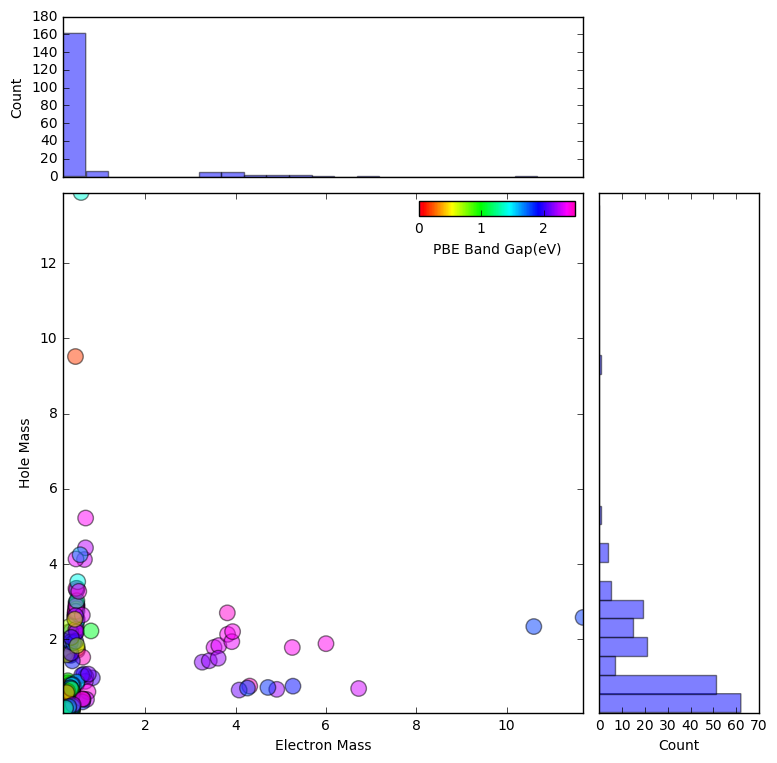

(array([ 0.05223421]), array([ 13.8776254]))

In [46]:
##new query for make the 2116 paper database overview figure, plotting band gap and effective mass together
## effective mass calculation for too small Eg is meaningless
h = df.query('B2_site_nonpolar==True and Eg_mine>0.1 and Mass_e==Mass_e and Mass_h==Mass_h')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h']]
print(h.shape)

from mmtools.plot.plots import scatter_hist
x = h[['Mass_e']].values
y = h[['Mass_h']].values
z = h[['Eg_mine']].values
fig = scatter_hist(x, y, z, 'Electron Mass', 'Hole Mass', 'PBE Band Gap(eV)')
#plt.savefig('/Users/yao/Google Drive/data/2116/2116 figure/overview_figure2/mass.pdf')
plt.show()

df.query('B2_site_nonpolar==True and Eg_mine>0.1 and Mass_e==Mass_e and Mass_h>8')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']]
    
min(y), max(y)

In [15]:
df.query('B2_site_nonpolar==True and Eg_mine>0.1 and Mass_e>10 and Mass_h==Mass_h')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']]

,compound,Eg_mine,Mass_e,Mass_h,Hull
2593,K$_2$CuScCl$_6$,1.86,10.60,2.34,0.02
3649,Rb$_2$CuScCl$_6$,1.87,11.69,2.58,0.00


In [16]:
df.query('B2_site_nonpolar==True and Eg_mine>0.1 and 2<Mass_e<10 and Mass_h<1')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']]

,compound,Eg_mine,Mass_e,Mass_h,Hull
2977,K$_2$InScCl$_6$,2.48,4.31,0.75,0.03
2978,K$_2$InScBr$_6$,2.15,4.08,0.65,0.00
2979,K$_2$InScI$_6$,1.84,4.26,0.70,0.00
4034,Rb$_2$InScBr$_6$,2.23,4.91,0.67,0.00
4035,Rb$_2$InScI$_6$,1.88,4.72,0.72,0.00
5090,Cs$_2$InScBr$_6$,2.31,6.72,0.69,0.00
5091,Cs$_2$InScI$_6$,1.95,5.27,0.75,0.00


In [17]:
df.query('B2_site_nonpolar==True and Eg_mine>0.1 and 2<Mass_e<10 and Mass_h>1')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']]

,compound,Eg_mine,Mass_e,Mass_h,Hull
2211,K$_2$NaScI$_6$,2.20,3.26,1.39,0.00
2307,K$_2$KScI$_6$,2.33,3.52,1.78,0.00
3267,Rb$_2$NaScI$_6$,2.21,3.42,1.43,0.00
3363,Rb$_2$KScI$_6$,2.34,3.63,1.83,0.00
3459,Rb$_2$RbScI$_6$,2.39,3.82,2.13,0.00
4131,Rb$_2$TlScI$_6$,2.40,5.26,1.78,0.00
4323,Cs$_2$NaScI$_6$,2.23,3.61,1.50,0.00
4419,Cs$_2$KScI$_6$,2.36,3.92,1.94,0.00
4515,Cs$_2$RbScI$_6$,2.40,3.93,2.20,0.00
4611,Cs$_2$CsScI$_6$,2.45,3.82,2.70,0.00


(1149, 4)


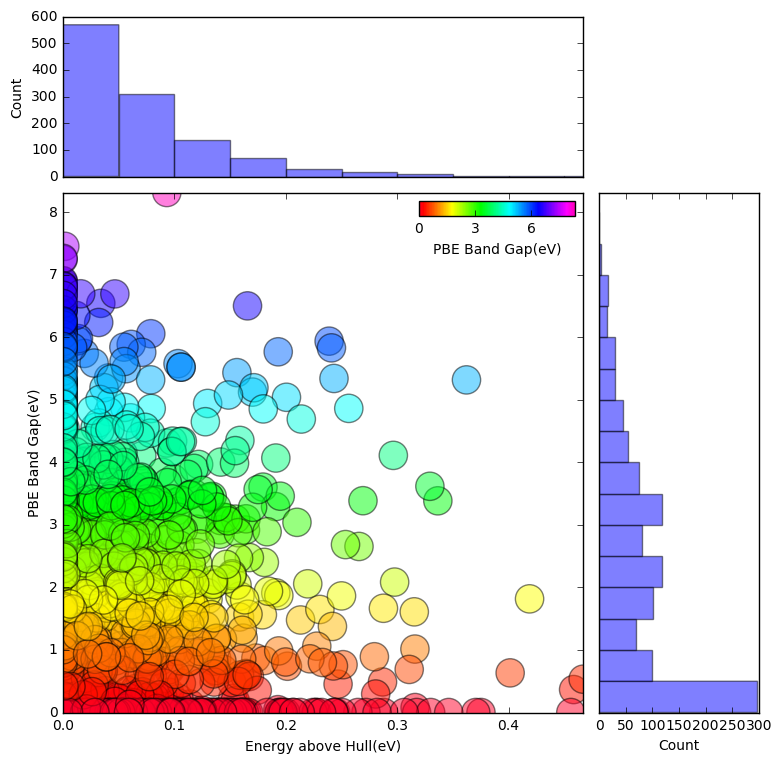

In [41]:
##new query for make the 2116 paper database overview figure, plotting band gap and hull together
hh = df.query('B2_site_nonpolar==True and Eg_mine==Eg_mine and Hull<0.5')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor']]
print(hh.shape)

from mmtools.plot.plots import scatter_hist
x = hh[['Hull']].values
y = hh[['Eg_mine']].values
z = hh[['Eg_mine']].values
fig = scatter_hist(x, y, z, 'Energy above Hull(eV)', 'PBE Band Gap(eV)', 'PBE Band Gap(eV)', x_binsize=0.05)
#plt.savefig('/Users/yao/Google Drive/data/2116/2116 figure/overview_figure2/hull.pdf')
plt.show()

In [23]:
##count the stables
df.query('B2_site_nonpolar==True and Hull<0.05')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor', 'Hull_path']].shape

(569, 5)

In [32]:
##count the stables and metals
df.query('B2_site_nonpolar==True and Hull<0.05 and Eg_mine==0')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor', 'Hull_path']].shape

(67, 5)

In [33]:
##count the stables and small gaps
df.query('B2_site_nonpolar==True and Hull<0.05 and 0<Eg_mine<2.5')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor', 'Hull_path']].shape

(199, 5)

In [34]:
##count the stables and large gaps
df.query('B2_site_nonpolar==True and Hull<0.05 and Eg_mine>=2.5')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor', 'Hull_path']].shape

(303, 5)

In [20]:
##outliers(Hull too large)
df.query('B2_site_nonpolar==True and Eg_mine==Eg_mine and Hull>0.5')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor', 'Hull_path']]

,compound,Eg_mine,Hull,tolerance_factor,Hull_path
2668,K$_2$CuInF$_6$,0.00,2.26,0.99,K3InF6 KCuF3 Cu KIn2F7
4900,Cs$_2$AuYF$_6$,2.06,0.80,0.92,Cs3YF6 YF3 Au CsAuF4


In [21]:
##Eg too large
df.query('B2_site_nonpolar==True and Eg_mine>8 and Hull==Hull')\
    [['compound', 'Eg_mine', 'Hull', 'tolerance_factor', 'Hull_path']]

,compound,Eg_mine,Hull,tolerance_factor,Hull_path
4580,Cs$_2$RbAlF$_6$,8.32,0.09,0.96,CsF CsAlF4 RbF


In [43]:
##count small electron mass
df.query('B2_site_nonpolar==True and Eg_mine>0.1 and Mass_e<1 and Mass_h==Mass_h')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']].shape

(167, 5)

In [44]:
##count small hole mass
df.query('B2_site_nonpolar==True and Eg_mine>0.1 and Mass_e==Mass_e and Mass_h<1')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']].shape

(111, 5)

In [73]:
##count small electron and hole mass
df.query('tolerance_factor > 0.82 and tolerance_factor<1.08 and octahedron_factor>0.4 and octahedron_factor<1.0 \
         and B2_site_nonpolar==True and Hull<0.05 and Eg_bs>0 and Eg_direct_bs<1.5\
         and Mass_e>0 and Mass_e<1.5 and Mass_h>0 and Mass_h<1.5')\
    [['compound', 'Eg_mine', 'Mass_e', 'Mass_h', 'Hull']].shape

(41, 5)